In [1]:
import pickle
 
with open('catalog_0.1-0.25Hz_2004-2020_6hours.pickle', mode='rb') as f:
    catalog = pickle.load(f)

# Data format
* 'date': Date
* 'Δ_in': Angular distanve measured from the curvature without 3-D correction [degree]
* 'px', 'py': Slowness withoug 3-D correction [s/km]
* 'lat_in': Latitude infered from the azimuth (arctan(py,px)) and Δ_in [degree]
* 'lon_in': Longitude infered from the azimuth (arctan(py,px)) and Δ_in [degre]
* 'dpdΔ': dp/dΔ [s/deg^2]
* 'δp': The modification of the sloness during the Newtonian method [s/km]
* 'δΔ': The modification of the angular distance during the Newtonian method [degree]
* 'ΔS': The modification of the normalized beam power during the Newtonian method
* 'num_ss': Number of segments for the events
* 'ε': This parameter shows the convergence of the Newtonian method
* 'fmax': The frequency for the maximum power [Hz]
* 'lat_ary': Latitude of the geocenter of the array [degree]
* 'lon_ary'; Longitude of the geocenter of the array [degree]
* 'Δ_rev': The angular distance inferred from the slowness with the 3-D correction [degree]
* 'Δ_curve' The angular distance inferred from the curvature with the 3-D correction [degree]
* 'CSF': The centroid dingle force [N]. If the source was located on land, 'CSF' is set to NaN.
* 'dpdΔ_ray': The ray theoretical value of dp/dΔ [s/deg^2]
* 'phase': Phase name (P, PP, PKP and PKIKP)
* 'depth': Water depth below the source
* 'max': The beampower [(m/s)^2/Hz] for the event
* 'mad': Median Absolude Deviation [(m/s)^2/Hz] wihch represents the noise level.
* 'subev': subevent number which shows number of the peaks of the initial beamforming resutls. This parameter is just for the check of the data.
* 'φ1': Azimuth of the error ellipse defined in the paper [degree]
* 'λ1': the semi-major length of the error ellipse [km]
* 'λ2': the semi-minor length of the error ellipse [km]
* 'cov': The covariance matrix defined in the paper


# Plot migration events

In [100]:
#Init
import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84  # define the WGS84 ellipsoid

[lat_rev,lon_rev,CSF,date_ev] = [np.array([event[field] for event in catalog ]) for field in ["lat_rev","lon_rev","CSF","date"]]
date_ev = [datetime.datetime.strptime(date_ev[i],"%Y%m%dT%H%M%S") for i in range(len(date_ev))]


In [101]:
date_obs = np.array([date_ev[0]]*len(date_ev))
date0 = datetime.datetime(2004,4,1,0,0,0)
date1 = datetime.datetime(2020,12,31,23,0,0)

cur = date0
iev, iev2, iev3 = 0, 0, 0
iev2_prev=0
#Fast forward
while date_ev[iev2] < date0: iev2 += 1
number = 0

events_obs = []
while cur < date1:
    #Obs
    lat_obs, lon_obs, csf_obs, date_obs = [], [] ,[], []
    while  (iev2 < len(date_ev)) and (date_ev[iev2] >= cur -  datetime.timedelta(hours=1)) and (date_ev[iev2] < cur + datetime.timedelta(hours=5)):
        if ~np.isnan(CSF[iev2]):
            lat_obs.append(lat_rev[iev2])
            lon_obs.append(lon_rev[iev2])
            csf_obs.append(CSF[iev2])
            date_obs.append(date_ev[iev2])
        iev2 += 1
    diff_t  =  (date_ev[iev2-1]-date_ev[iev2_prev-1]).total_seconds()
    obs_prev = np.full(len(lon_obs),     -1, dtype=int)
    if number > 0:  obs_next = np.full(len(lon_obs_prev),-1, dtype=int)
    if diff_t < 3600*7  and diff_t > 3600 and iev2_prev > 0: 
        for i in range(len(lat_obs)):
            dist, j_min = 1E4, -1
            for j in range(len(lat_obs_prev)):
                dist_2 = geod.Inverse(lat_obs_prev[j],lon_obs_prev[j],lat_obs[i],lon_obs[i])["s12"]*1E-3
                if dist_2 < dist: 
                    dist = dist_2
                    j_min = j
            if dist < 600: 
                obs_prev[i]     = j_min
                obs_next[j_min] = i

    iev2_prev = iev2
    lat_obs_prev,lon_obs_prev,csf_obs_prev,date_obs_prev = lat_obs.copy(), lon_obs.copy(),csf_obs.copy(), date_obs.copy()

    events_obs.append({"lat":lat_obs,"lon":lon_obs,"csf":csf_obs,"prev":obs_prev,"date":cur})
    if number > 0: events_obs[number-1]["next"] = obs_next

    number += 1 
    cur += datetime.timedelta(hours=6)
events_obs[-1]["next"] =np.array([-1])


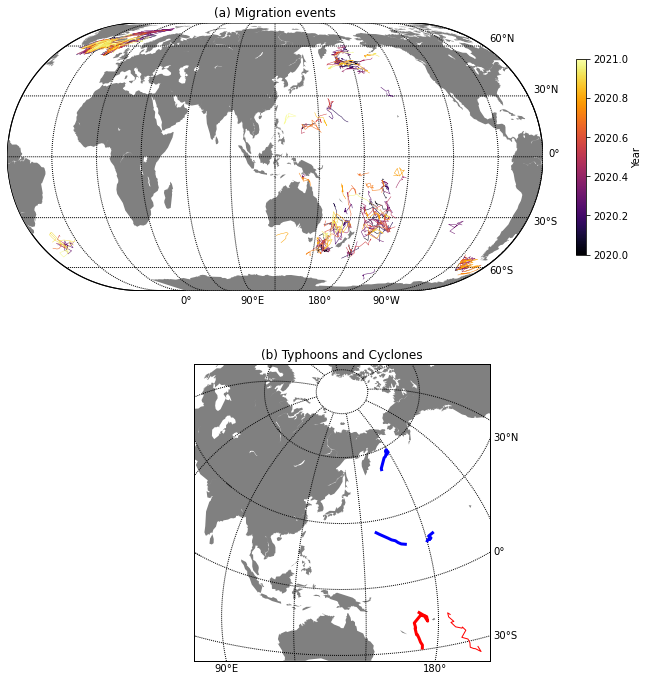

In [102]:
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

fig, axs = plt.subplots(2,1,figsize=(12,12))
map0 = Basemap(projection='eck4',lon_0=-240, ax=axs[0])
map1 = Basemap(projection='aeqd',lon_0=140, lat_0=35,width=15000000,height=15000000,ax=axs[1])

for map in [map0,map1]:
    map.shadedrelief(scale=0.1,alpha=.5)
    map.drawparallels(np.arange(-90,90,30),labels=[0,1,0,0])
    map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,0])
    map.drawmeridians(np.arange(-180,180,90),labels=[0,0,0,1],linewidth=0)
    map.drawmapboundary()#fill_color='#99ffff')
    map.fillcontinents(color='gray')

cluster = []
for idy in range(len(events_obs)):
    num_ev =  len(events_obs[idy]["lon"])
    for i in range(num_ev):
        if events_obs[idy]["prev"][i] == -1:
            lon_tmp = [events_obs[idy]["lon"][i]]
            lat_tmp = [events_obs[idy]["lat"][i]]

            idy2 = idy
            next = events_obs[idy2]["next"][i] 
            while next != -1:
                lon_tmp.append(events_obs[idy2+1]["lon"][next])
                lat_tmp.append(events_obs[idy2+1]["lat"][next])
                next =         events_obs[idy2+1]["next"][next]
                idy2 += 1
            lon_tmp = np.array(lon_tmp)

            #A definition of events:
            flag_IOKE = (events_obs[idy]["date"] > datetime.datetime(2006,8,27)and events_obs[idy]["date"] <= datetime.datetime(2006,9,10)) \
                and (events_obs[idy]["lon"][i] > 130 or events_obs[idy]["lon"][i] <-150) and events_obs[idy]["lat"][i] > 0   #IOKE
            flag_WB   = (events_obs[idy]["date"] > datetime.datetime(2014,12,8)and events_obs[idy]["date"] <= datetime.datetime(2014,12,14))\
                and (events_obs[idy]["lon"][i] > -60 or events_obs[idy]["lon"][i] <20) and events_obs[idy]["lat"][i] > 50   #WB
            flag_PAM  = (events_obs[idy]["date"] > datetime.datetime(2015,3,10)and events_obs[idy]["date"] <= datetime.datetime(2015,3,16))\
                and (events_obs[idy]["lon"][i] > 130 or events_obs[idy]["lon"][i] <-150) and events_obs[idy]["lat"][i] < 0   #PAM
            flag_LIN  = (events_obs[idy]["date"] > datetime.datetime(2009,3,31)and events_obs[idy]["date"] <= datetime.datetime(2009,4,9))\
                and (events_obs[idy]["lon"][i] > 130 or events_obs[idy]["lon"][i] <-100) and events_obs[idy]["lat"][i] < 0  and events_obs[idy]["lat"][i] > -40  #LIN

            if idy2 - idy >= 4 and flag_IOKE: 
                xev, yev = map(lon_tmp,lat_tmp)
                map1.plot(xev,yev,color="blue",lw=3)
            if idy2 - idy >= 4 and flag_WB: 
                xev, yev = map(lon_tmp,lat_tmp)
                map1.plot(xev,yev,color="green",lw=3)
            if idy2 - idy >= 4 and flag_PAM: 
                xev, yev = map(lon_tmp,lat_tmp)
                map1.plot(xev,yev,color="red",lw=3)
            if idy2 - idy >= 4 and flag_LIN: 
                xev, yev = map(lon_tmp,lat_tmp)
                map1.plot(xev,yev,color="red",lw=1)
            if idy2 - idy >= 8:
                xev, yev = map0(lon_tmp,lat_tmp)
                cs = map0.plot(xev,yev,lw=0.5,c=cm.inferno(idy/len(events_obs)))

norm = mpl.colors.Normalize(vmin=2004.25, vmax=2021)
norm = mpl.colors.Normalize(vmin=2020., vmax=2021)

fig.colorbar(cm.ScalarMappable(norm= norm, cmap=cm.inferno),ax=axs[0], shrink=.66,label="Year")
axs[0].set_title("(a) Migration events")
axs[1].set_title("(b) Typhoons and Cyclones")

plt.show()
